## 1. Checking Dependencies
Installing and importing required libraries

In [52]:
# %pip install matplotlib
# %pip install numpy pandas 
# %pip install scikit-learn scikit-image 
# %pip install seaborn
# %pip install StandardScaler
# %pip install statsmodels
# %pip install ipykernel
# %pip install --upgrade nbformat

In [53]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import math 
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import plotly.express as px
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.linear_model import PoissonRegressor

bestX = None


## 2. Methods Defination
This methods are used several times in trainig model



In [54]:
def readOriginalData():
    #TODO: change path to links
    train_data_link = "/home/karan/Templates/SemV_Assignments/Machine_Learning/Assingnment1/data/MaterialStrength_Train.csv"
    test_data_link = "/home/karan/Templates/SemV_Assignments/Machine_Learning/Assingnment1/data/MaterialStrength_test.csv"

    # data = pd.read_csv(train_data_link)
    trainData = pd.read_csv(train_data_link) 
    testData = pd.read_csv(test_data_link)

    return trainData,testData

In [55]:
def seperateData(data,randomNumber=860):
    trainData , testData = train_test_split(data, test_size=0.2, shuffle=True,random_state=randomNumber)

    trainData.reset_index(inplace=True,drop=True)
    testData.reset_index(inplace=True,drop=True)

    return trainData, testData

In [56]:
def testFeature(data,featureName,compareFeature):
    corrMatrix = data.corr()

    sortData = corrMatrix["Material Strength"].sort_values(ascending=True)
    # print(sortData)
    print(featureName, " corelation ==>",sortData[featureName])
    print(compareFeature," corelation ==>",sortData[compareFeature])

    figure, axis = plt.subplots(nrows=2,ncols=2,figsize=(8,4*2))
    axis = axis.flatten()
    oldKdePlot = sns.scatterplot(data,x=compareFeature,y="Material Strength",ax=axis[0])
    newKdePlot = sns.scatterplot(data,x=featureName,y="Material Strength",ax=axis[1])
    oldBoxPlot = sns.boxplot(data,y=compareFeature,ax=axis[2])
    newBoxPlot = sns.boxplot(data,y=featureName,ax=axis[3])
    plt.tight_layout()

In [57]:
def outlierRange(data, quan1=0.25, quan3=0.75):
    firstQuantile = data.quantile(quan1)
    thirdQuantile = data.quantile(quan3)

    IQR = thirdQuantile - firstQuantile 

    upperBound = firstQuantile + 1.5 * IQR
    lowerBound = thirdQuantile - 1.5 * IQR 
    return lowerBound, upperBound

In [58]:
def plotGraph(data,cols,plot="box"):
    nrows = math.ceil(len(cols)/3)
    figure, axis = plt.subplots(nrows=nrows,ncols=3,figsize=(12,4*nrows))
    axis = axis.flatten()
    for i in range(len(cols)):
        if(plot=="box"):
            boxPlot = sns.boxplot(data,y=cols[i],ax=axis[i])
        elif(plot=="scatter"):
            scatterPlot = sns.scatterplot(data,x=cols[i],y="Material Strength",ax=axis[i])
        elif (plot=="violin"):
            violinPlot = sns.violinplot(data,y=cols[i],ax=axis[i])
        else:
            kdePlot = sns.kdeplot(data,x=cols[i],ax=axis[i])
    plt.tight_layout()

In [59]:
def countOutlier(data,colName):
    lower_limit, upper_limit = outlierRange(data[colName])
    condition = (data[colName] < lower_limit) | (data[colName] > upper_limit)
    changedData = data[condition]
    print("outliers in ",colName," ==> ",changedData.shape[0])

In [60]:
# TODO: update function at last
def transformDataSet(testData):
    testData["waterPerCement"] = testData["water"]/np.log(testData["cement"])
    testData["cementPerWaterVolume"] = testData["cement"]/pow(testData["water"],0.3)
    testData["fineAggregatePerWaterVolume"] = testData["fine_aggregate "]*pow(testData["water"],3)
    testData["newAge"] = pow(np.log(testData["age"]),1.5)
    testData["newSuperPlasticzer"] = pow(testData["superplasticizer"],0.7) 
    testData["newFineAggregate"] =  1/1+pow(1+np.log(testData["fine_aggregate "]*(testData["cement"]**2)),-0.5)
    testData["newBlastFurnaceSlag"] = (1/(testData["blast_furnace_slag"]-1))
    return testData
            
       

In [61]:
def bestFitCoeffMatrix(matrix_A,matrix_b):
    matrix_A = np.column_stack((np.ones(matrix_A.shape[0]), matrix_A))
    # print(matrix_A[:][10:11])
    psedoInv_A = np.dot(matrix_A.transpose(),matrix_A)
    # print(psedoInv_A[:][10:11])
    psedoInv_A = np.linalg.inv(psedoInv_A)
    psedoInv_A = np.dot(psedoInv_A,matrix_A.transpose())

    bestX = np.dot(psedoInv_A, matrix_b)
    return bestX

In [62]:
def predictValue(matrix_A,matrix_x):
    matrix_A = np.column_stack((np.ones(matrix_A.shape[0]), matrix_A))
    matrix_p = np.matmul(matrix_A,matrix_x)
    
    return matrix_p

In [63]:
def getMeanSquareError(trainData,testData):
    # first we will perform transformation of test data according to train data
    # testData = transformDataSet(testData)

    # drop the nan values otherwise it will be headache in matrix multiplication
    trainData.dropna(inplace=True)
    testData.dropna(inplace=True)

    trainData.drop_duplicates()
    # print(trainData["Material Strength"][:10])
    
    # seperate features to label(train_b matrix) and variable(train_A)
    train_A = trainData.drop("Material Strength",axis=1)
    test_A = testData.drop("Material Strength",axis=1)

    train_b = trainData["Material Strength"]
    test_b = testData["Material Strength"]

    # standardization  
    object= StandardScaler()
    scale = object.fit_transform(train_A) 
    train_A = pd.DataFrame(scale,columns=train_A.columns)
    scale = object.fit_transform(test_A) 
    test_A = pd.DataFrame(scale,columns=test_A.columns)

    # coefff. matrix
    # print(train_b[:10])
    train_x = bestFitCoeffMatrix(train_A,train_b)
    bestX = train_x
    test_x = bestFitCoeffMatrix(test_A,test_b)

    # predicted value
    train_p = predictValue(train_A,train_x.reshape(train_x.shape[0],1))
    test_p = predictValue(test_A,test_x.reshape(test_x.shape[0],1))

    # mean squre error
    trainMSE = meanSquareError(train_b,train_p)
    testMSE = meanSquareError(test_b,test_p)
    return trainMSE,testMSE

In [64]:
def meanSquareError(actualValue,predictedValue):
    actualValue = np.array(actualValue).reshape((actualValue.shape[0],1))
    predictedValue = predictedValue.reshape((predictedValue.shape[0],1))

    errorMatrix = actualValue - predictedValue

    errorSquare = np.dot(errorMatrix.transpose(),errorMatrix)
    MSE = errorSquare[0][0] / actualValue.shape[0]
    return MSE

In [65]:
def olsStatic(data):
    data_b = data['Material Strength']
    data_A = data.drop('Material Strength',axis=1)
    data_A["constant"] = 1

    result=sm.OLS(data_b,data_A).fit()
    print(result.summary())

In [111]:
def gradientDescent(data, learningRate, iterations):

    try:
        data_A = data.drop('material_strength', axis=1)
    except:
        data_A = data.drop('Material Strength', axis=1)


    object= StandardScaler()
    scale = object.fit_transform(data_A) 
    data_A = pd.DataFrame(scale,columns=data_A.columns)

    # Add a column of ones to X for the bias term
    data_A = np.column_stack((np.ones(data_A.shape[0]), data_A)) #620,16

    try:
        data_b = data['material_strength']# 620,1
    except:
        data_b = data["Material Strength"]
    data_n = data_b.shape[0]

    # Initialize theta (model parameters)
    totalFeatures = data_A.shape[1]
    data_x = np.random.randn(totalFeatures, 1)#16,1
    data_b = np.array(data_b)
    data_b = data_b.reshape((data_b.shape[0],1))

    errorHistory = []
    validationHistory = []

    for i in range(iterations):
        # Calculate predictions
        predictions = np.matmul(data_A,data_x)

        # Calculate the error
        error = predictions - data_b

        # Calculate the gradient
        gradient =   (2/data_n) * np.matmul(data_A.T,error)

        # Update data_x 
        data_x = data_x - learningRate* gradient

        # Calculate and record the loss (Mean Squared Error)
        MSE = meanSquareError(data_b,predictions)

        # print(MSE)
        errorHistory.append(MSE)
        # validationHistory.append(np.mean((data_A.dot(data_x)-predictions)**2))
        # Convergence Criterion: Stop when the change in loss is small
        if iterations > 0 and i>2:
            validationHistory.append(errorHistory[-1]-errorHistory[-2])
            if (abs(errorHistory[-1] - errorHistory[-2]) < 0.000000001):
                print("BREAK....")
                break

    return data_x, errorHistory,validationHistory

## 3.EDA and Feature Engineering 
Using EDA techniques to visualize, cleaning and pre-processing data. Making validation set and checking mean square error. 

In [67]:
# Reading Data
originalTrainData, originalTestData = readOriginalData()

# Printing size of data 
print("Size of Training Data : ", originalTrainData.shape)
print("Size of Testing Data : ", originalTestData.shape)

Size of Training Data :  (800, 9)
Size of Testing Data :  (230, 9)


In [68]:
originalTrainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cement              800 non-null    float64
 1   blast_furnace_slag  800 non-null    float64
 2   fly_ash             800 non-null    float64
 3   water               800 non-null    float64
 4   superplasticizer    800 non-null    float64
 5   coarse_aggregate    800 non-null    float64
 6   fine_aggregate      800 non-null    float64
 7   age                 800 non-null    int64  
 8   Material Strength   800 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 56.4 KB


- As we can thier is no null values present in any feature. Also all are of data type float or int.

In [69]:
originalTrainData.describe()
originalTestData.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,material_strength
count,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,0.0
mean,241.634783,95.032174,76.369565,187.786522,7.982609,928.978261,756.725652,31.630435,NaN
std,97.568515,84.002486,67.482339,16.770140,4.398447,78.652002,68.348952,31.581985,NaN
min,132.000000,0.000000,0.000000,127.000000,0.000000,801.000000,612.000000,3.000000,NaN
25%,152.150000,0.000000,0.000000,178.000000,6.000000,868.700000,698.125000,28.000000,NaN
50%,253.550000,116.000000,90.650000,187.800000,8.000000,922.800000,762.950000,28.000000,NaN
75%,312.700000,164.000000,128.000000,196.000000,10.400000,985.800000,809.950000,28.000000,NaN
max,525.000000,260.000000,200.100000,247.000000,22.100000,1125.000000,896.000000,360.000000,NaN


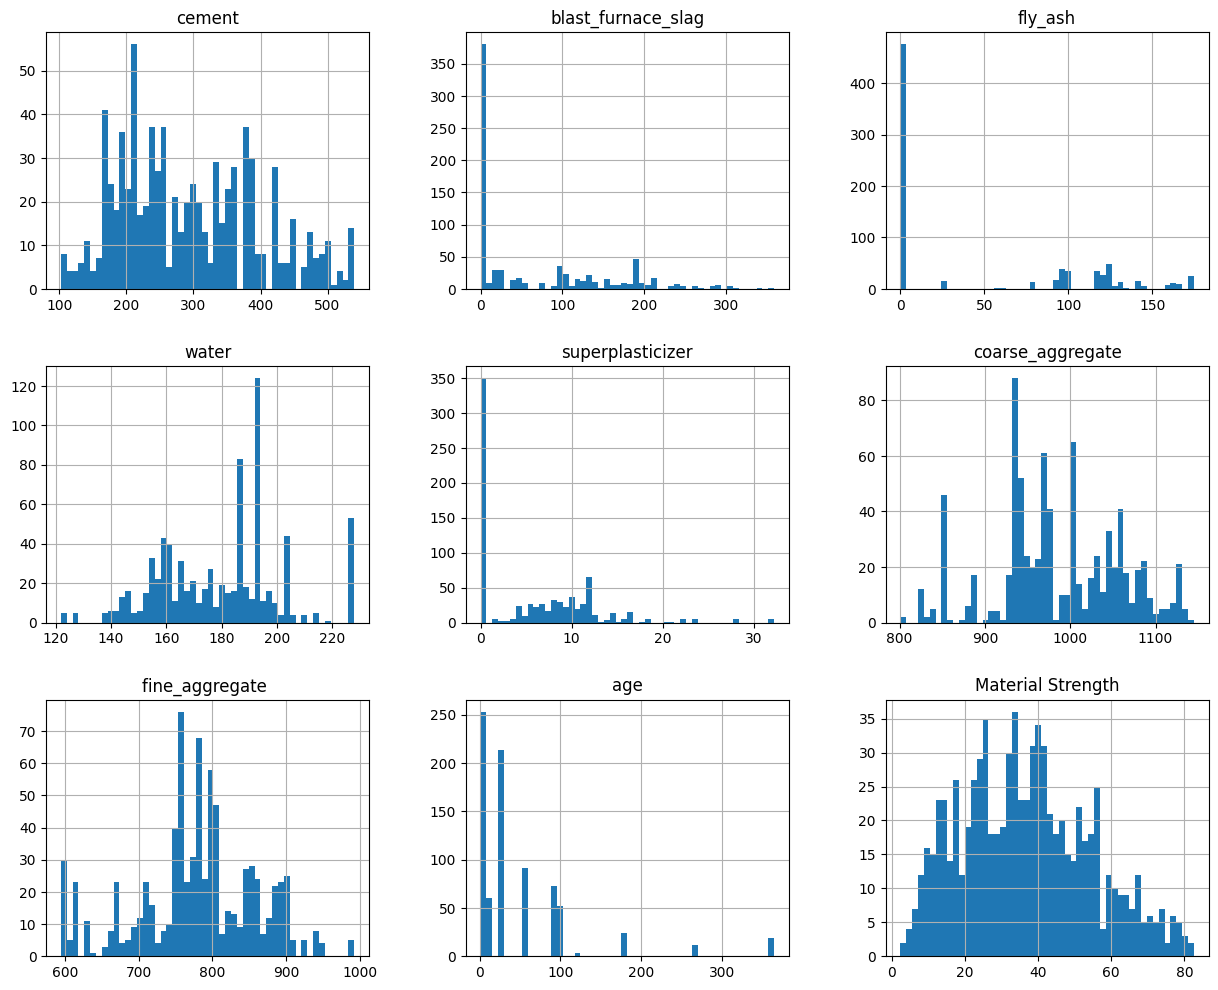

In [70]:
originalTrainData.hist(bins=50,figsize=(15,12))
plt.show()

- from histogram we can observe that values of superplasticizer, blast_furnace_slag and fly ash are mostly concentrated at zero

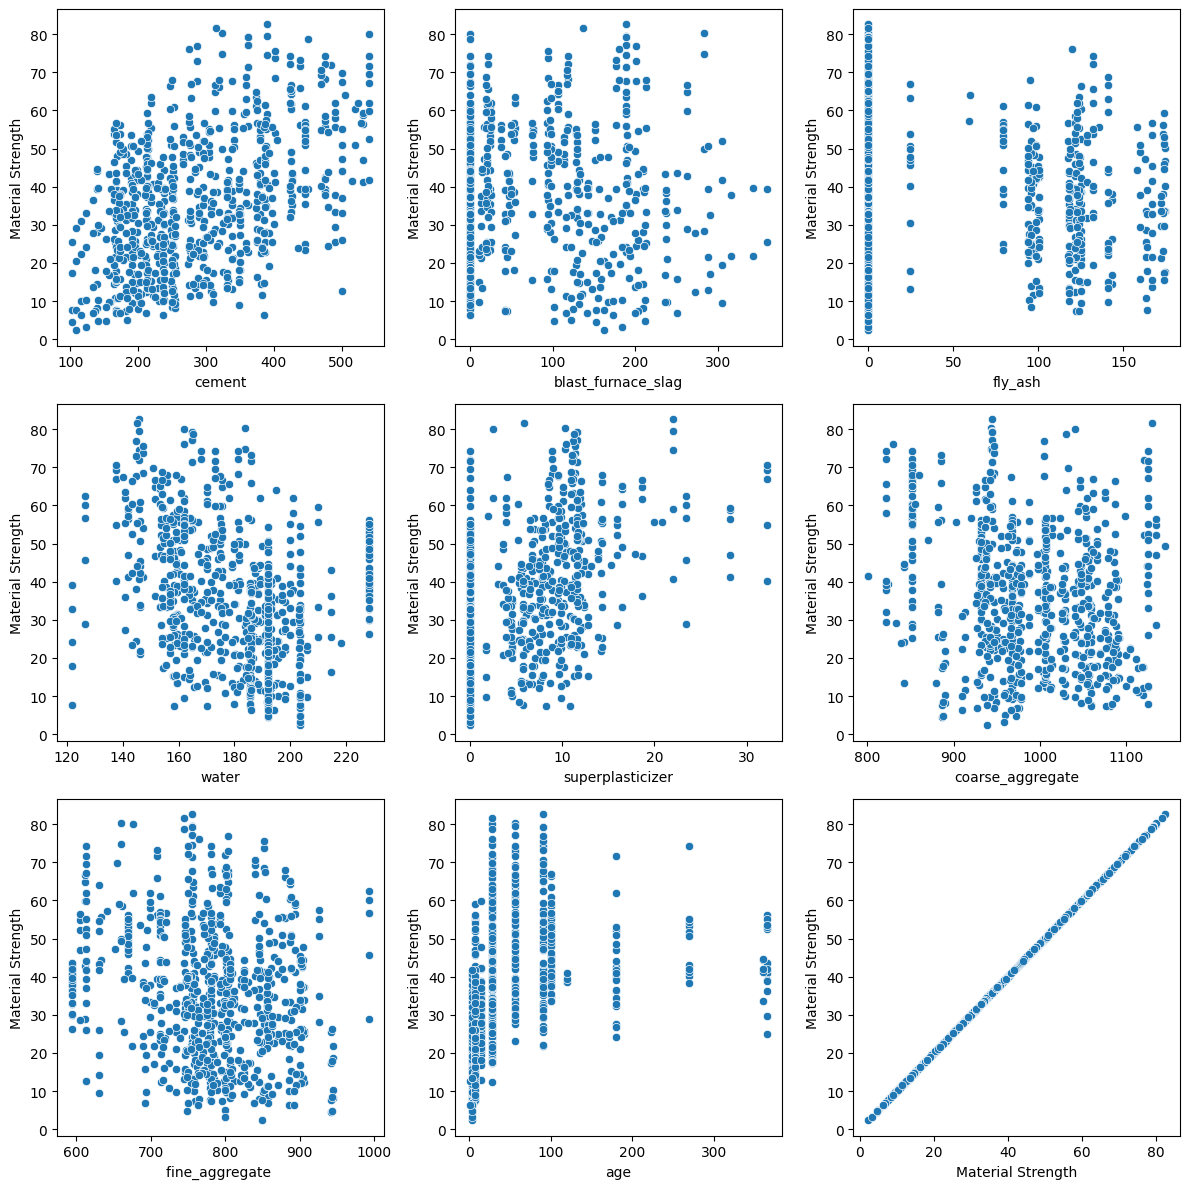

In [71]:
plotGraph(originalTrainData,originalTrainData.columns,"scatter")

### 3.1 Splitting training data into train and split

In [72]:
trainData , testData = seperateData(originalTrainData)
print(trainData.shape)
print(testData.shape)

(640, 9)
(160, 9)


In [73]:
trainData.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,Material Strength
0,334.0,17.6,158.0,189.0,15.3,967.0,633.0,28,44.33
1,424.0,22.0,132.0,178.0,8.5,822.0,750.0,56,65.70
2,350.0,0.0,0.0,186.0,0.0,1050.0,770.0,28,34.29
3,275.0,0.0,0.0,183.0,0.0,1088.0,808.0,7,14.20
4,284.0,15.0,141.0,179.0,5.5,842.0,801.0,3,13.40


In [74]:
testData.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,Material Strength
0,275.1,0.0,121.4,159.5,9.9,1053.6,777.5,100,58.61
1,387.0,20.0,94.0,157.0,13.9,938.0,845.0,7,45.90
2,166.1,0.0,163.3,176.5,4.5,1058.6,780.1,14,25.48
3,389.9,189.0,0.0,145.9,22.0,944.7,755.8,56,79.40
4,250.0,0.0,95.7,187.4,5.5,956.9,861.2,56,38.33


### 3.2 Studying Correlation

In [75]:
corrMatrix = originalTrainData.corr()
corrMatrix

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,Material Strength
cement,1.000000,-0.207007,-0.344930,-0.052637,0.239871,-0.280034,-0.289854,0.049899,0.470882
blast_furnace_slag,-0.207007,1.000000,-0.413947,0.111956,-0.009954,-0.263807,-0.291447,-0.017040,0.128704
fly_ash,-0.344930,-0.413947,1.000000,-0.402815,0.329412,0.188602,0.181276,-0.143028,-0.015736
water,-0.052637,0.111956,-0.402815,1.000000,-0.769979,-0.102044,-0.464590,0.330822,-0.298688
superplasticizer,0.239871,-0.009954,0.329412,-0.769979,1.000000,-0.222680,0.290716,-0.175616,0.466865
coarse_aggregate,-0.280034,-0.263807,0.188602,-0.102044,-0.222680,1.000000,-0.209472,-0.065710,-0.214502
fine_aggregate,-0.289854,-0.291447,0.181276,-0.464590,0.290716,-0.209472,1.000000,-0.197211,-0.188004
age,0.049899,-0.017040,-0.143028,0.330822,-0.175616,-0.065710,-0.197211,1.000000,0.339825
Material Strength,0.470882,0.128704,-0.015736,-0.298688,0.466865,-0.214502,-0.188004,0.339825,1.000000


In [76]:
corrMatrix["Material Strength"].sort_values(ascending=False)

Material Strength     1.000000
cement                0.470882
superplasticizer      0.466865
age                   0.339825
blast_furnace_slag    0.128704
fly_ash              -0.015736
fine_aggregate       -0.188004
coarse_aggregate     -0.214502
water                -0.298688
Name: Material Strength, dtype: float64

- As from above data we can see that Material Strength is strongly connected to cement, superplasticizer, age, water. 

/home/karan/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



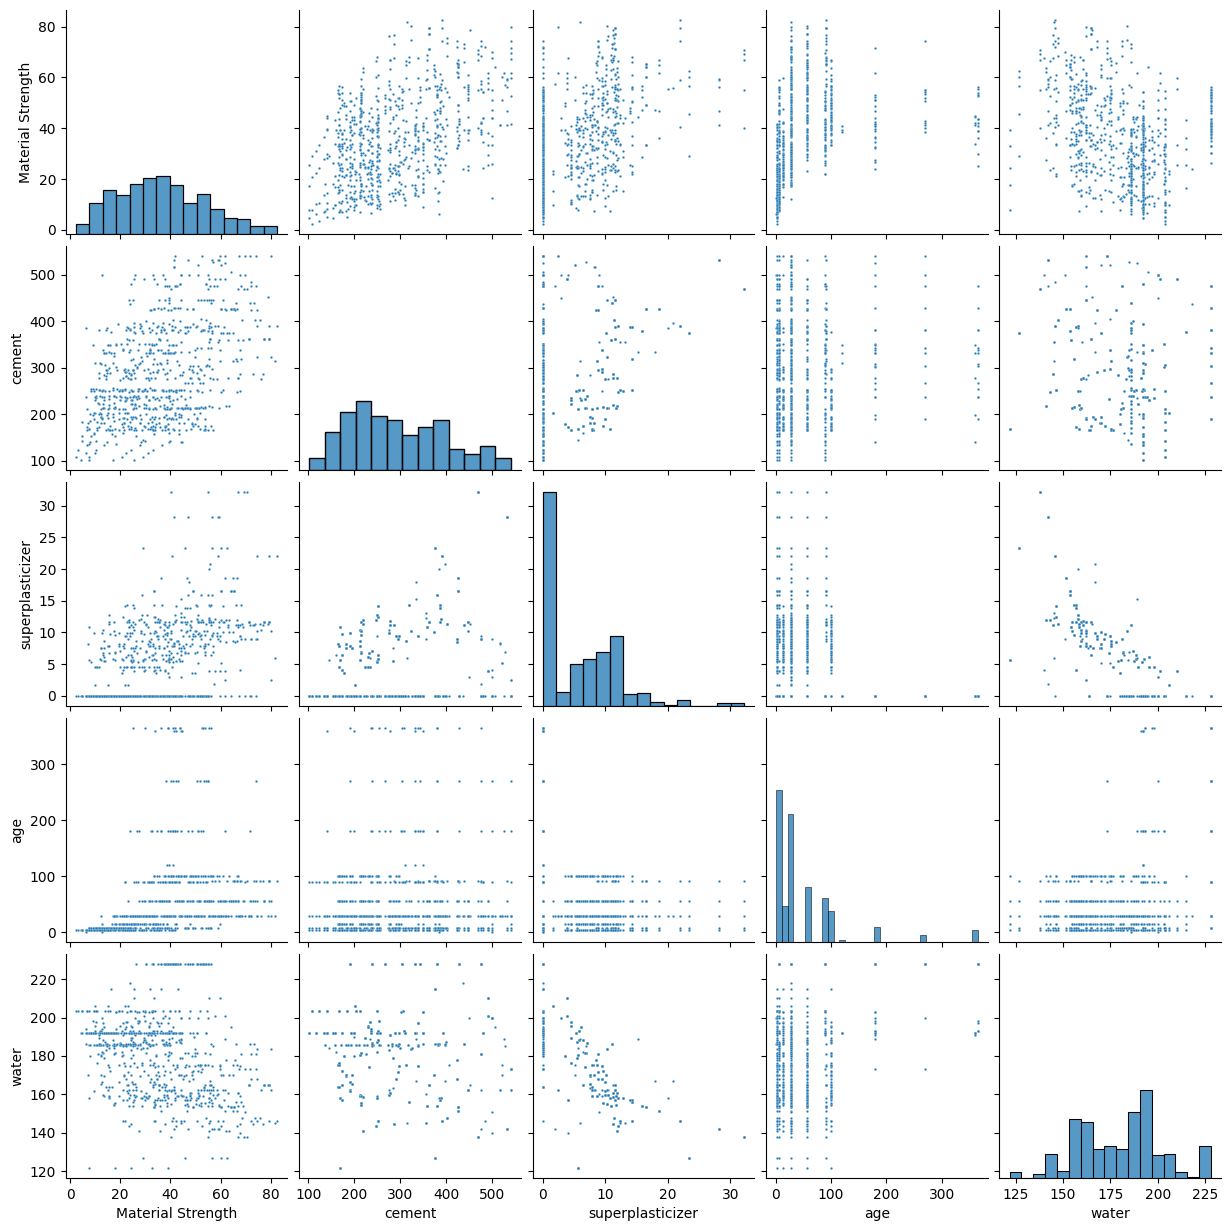

In [77]:
strongAttributes = ["Material Strength","cement","superplasticizer","age","water"]

sns.pairplot(originalTrainData[strongAttributes],plot_kws={"s":3})
plt.show()

- Observations
    1. From this pariplot we can see that age is mostly discreate.
    2. Cement is positively corelated to superplasticizer under some range.
    3. Cement is also positively corelated to Material Strenght.
    

- we can't estimate much from this graph as we have very less number of data points. Mostly graphs having scattered points which we can't show any specific relation



### 3.3 Finding New strongly correlated features

waterPerCement  corelation ==> -0.49044868291007954
cement  corelation ==> 0.4928001687900257


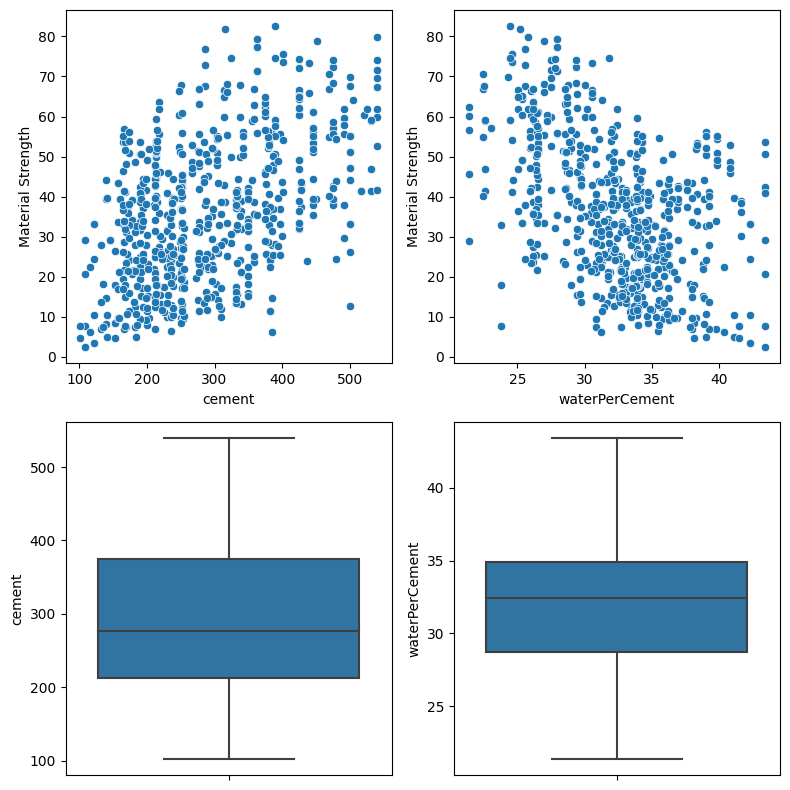

In [78]:
trainData["waterPerCement"] = trainData["water"]/np.log(trainData["cement"])
testFeature(trainData,"waterPerCement","cement")

cementPerWaterVolume  corelation ==> 0.522199070363663
cement  corelation ==> 0.4928001687900257


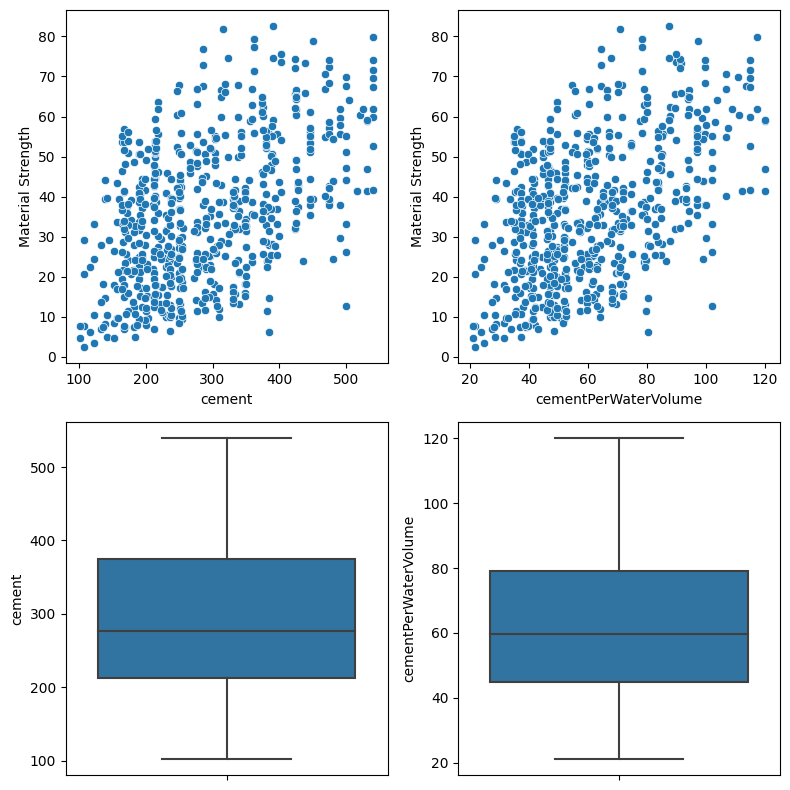

In [79]:
trainData["cementPerWaterVolume"] = trainData["cement"]/pow(trainData["water"],0.3)
testFeature(trainData,"cementPerWaterVolume","cement")

fineAggregatePerWaterVolume  corelation ==> -0.405669897975908
fine_aggregate   corelation ==> -0.19928503655739585


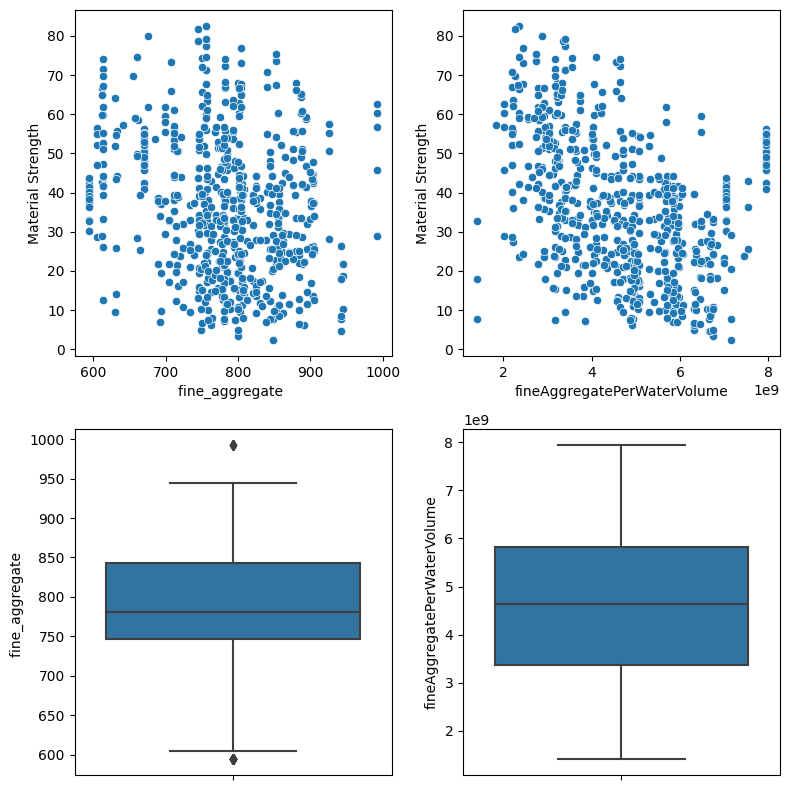

In [80]:
trainData["fineAggregatePerWaterVolume"] = trainData["fine_aggregate "]*pow(trainData["water"],3)
testFeature(trainData,"fineAggregatePerWaterVolume","fine_aggregate ")

### 3.3 Data Cleaning 
 - handling Outlier 
 - replace null values
 - Remove duplicates

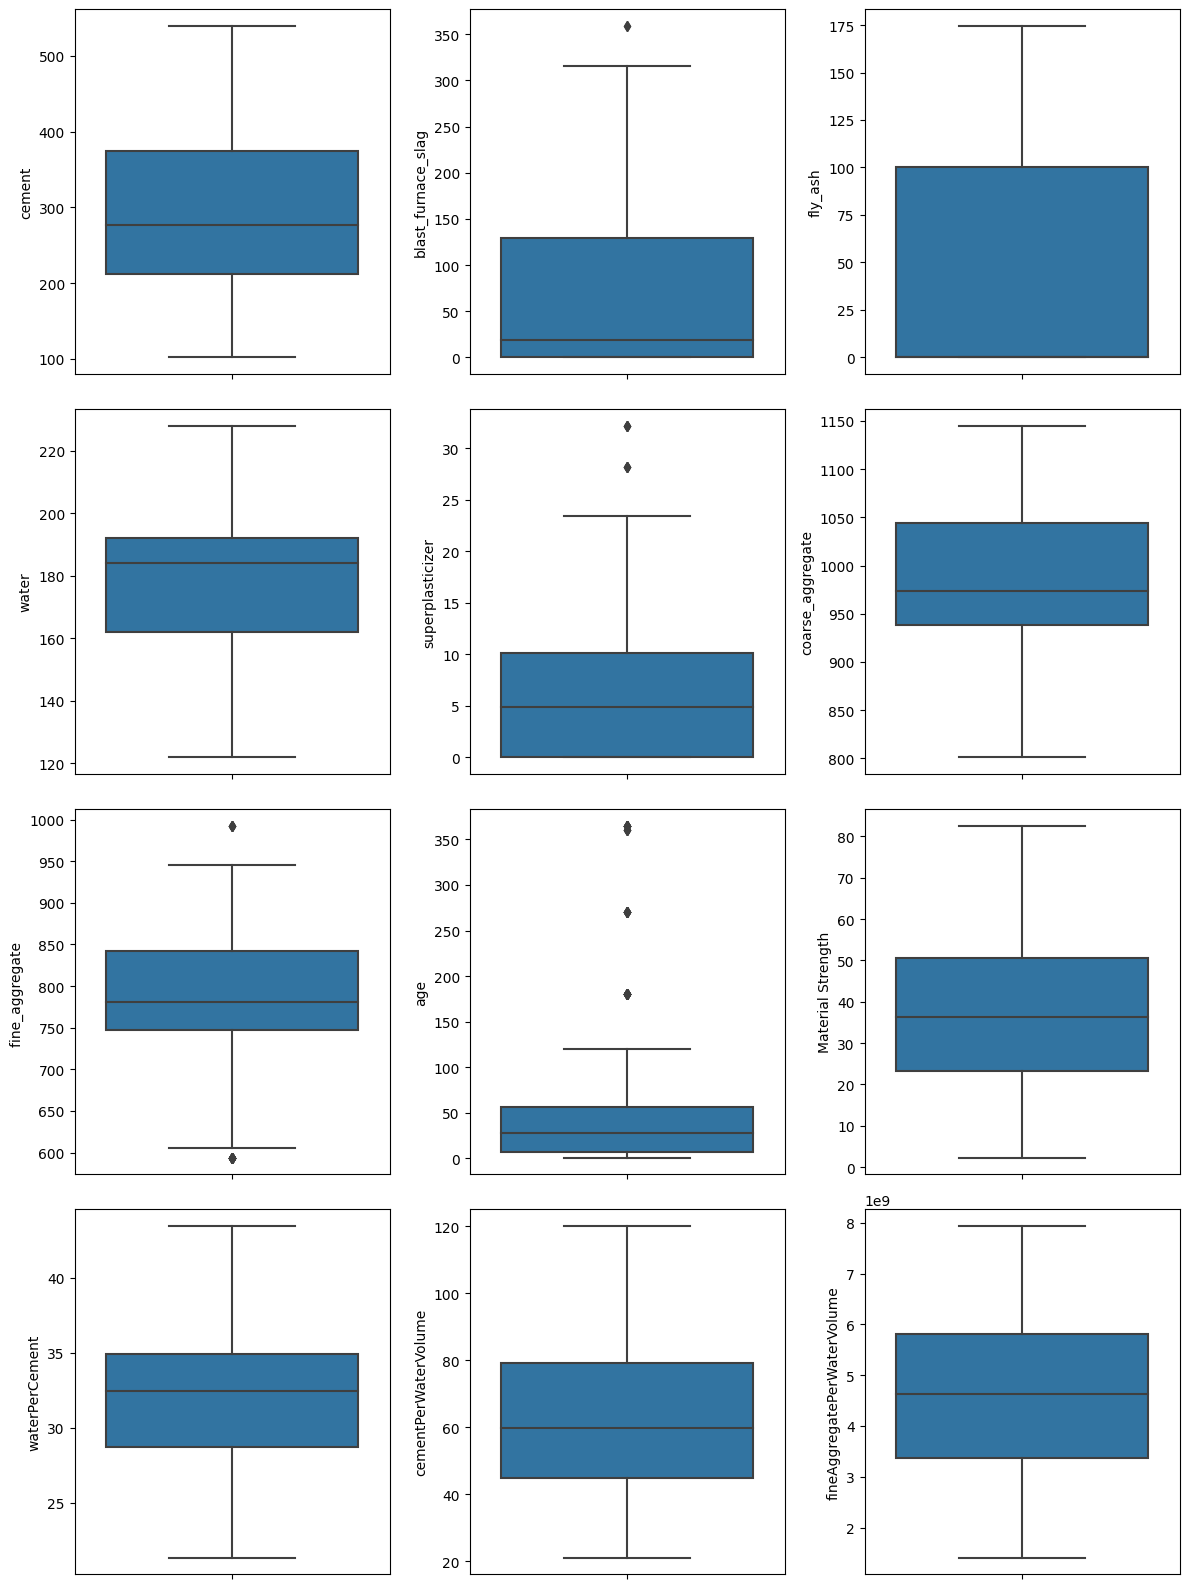

In [81]:
# checking outliers
plotGraph(trainData,trainData.columns)

In [82]:
# print("upper and lower bounds for outliers are")
print("outlier bounds")
print("age                ==>",outlierRange(trainData["age"]))
print("superplasticizer   ==>",outlierRange(trainData["superplasticizer"]))
print("fine_aggregate     ==>",outlierRange(trainData["fine_aggregate "]))
print("blast_furnace_slag ==>",outlierRange(trainData["blast_furnace_slag"]))


outlier bounds
age                ==> (-17.5, 80.5)
superplasticizer   ==> (-5.049999999999999, 15.149999999999999)
fine_aggregate     ==> (698.6, 890.6)
blast_furnace_slag ==> (-64.4125, 193.23749999999998)


Instead of just removing outliers we can try to move change feature such that their is no outliers

outliers in  age  ==>  155
outliers in  newAge  ==>  46
newAge  corelation ==> 0.5736815461802544
age  corelation ==> 0.3423623018718558


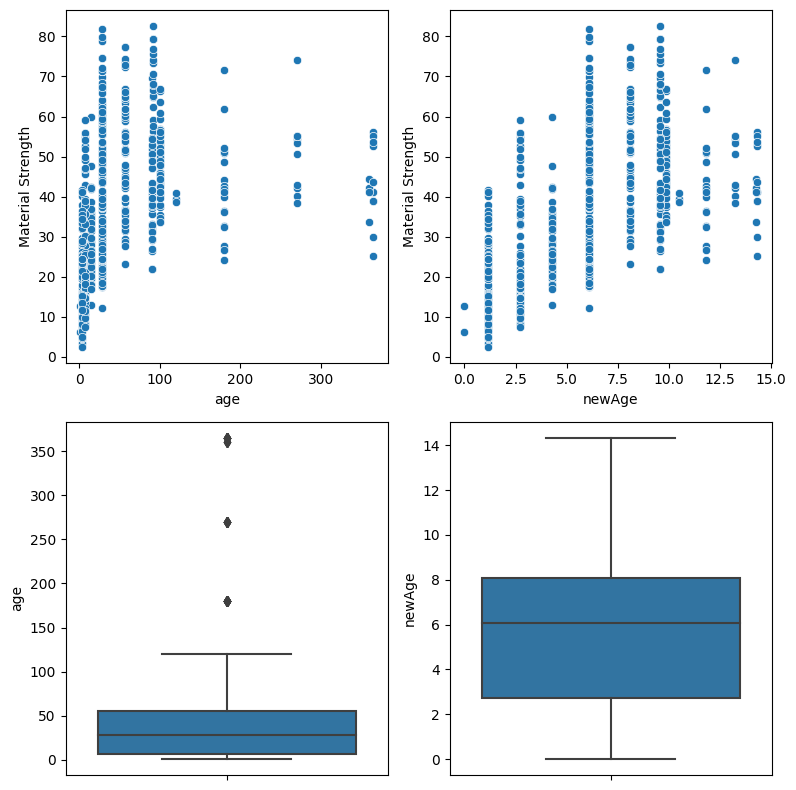

In [83]:
## handling outliers from age
oldName = "age"
newName = "newAge"
trainData[newName] = pow(np.log(trainData[oldName]),1.5)
countOutlier(trainData,oldName)
countOutlier(trainData,newName)
testFeature(trainData,newName,oldName)

outliers in  superplasticizer  ==>  43
outliers in  newSuperPlasticizer  ==>  23
newSuperPlasticizer  corelation ==> 0.47676931884550217
superplasticizer  corelation ==> 0.47507335719981414


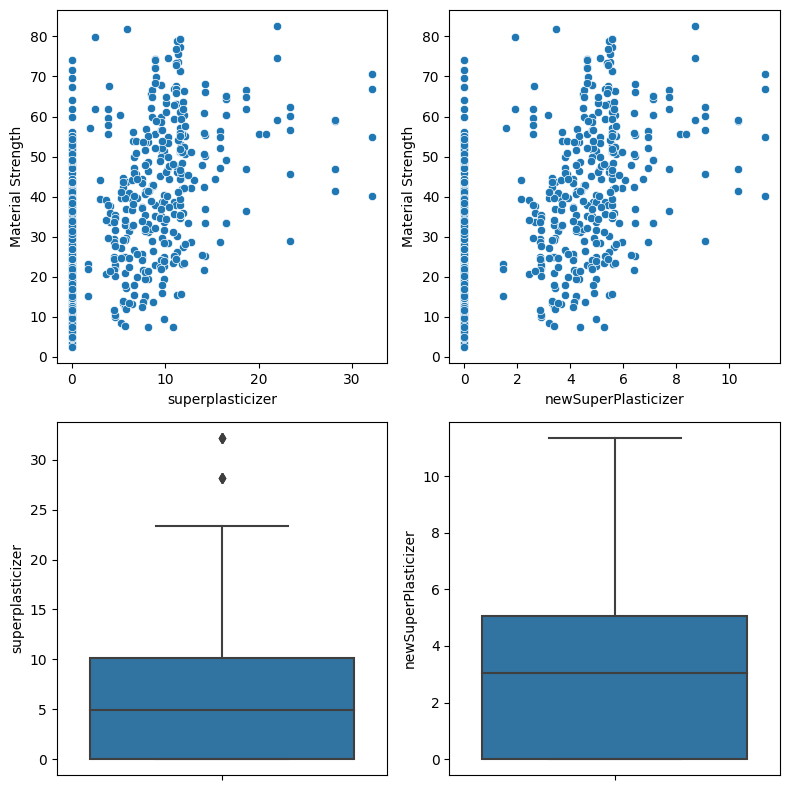

In [84]:
## handling outliers from superplasticizer
newName = "newSuperPlasticizer"
oldName = "superplasticizer"
trainData[newName] = pow(trainData[oldName],0.7) 
countOutlier(trainData,oldName)
countOutlier(trainData,newName)
testFeature(trainData,newName,oldName)

outliers in  fine_aggregate   ==>  149
outliers in  newFineAggregate  ==>  59
newFineAggregate  corelation ==> -0.4690791782800939
fine_aggregate   corelation ==> -0.19928503655739585


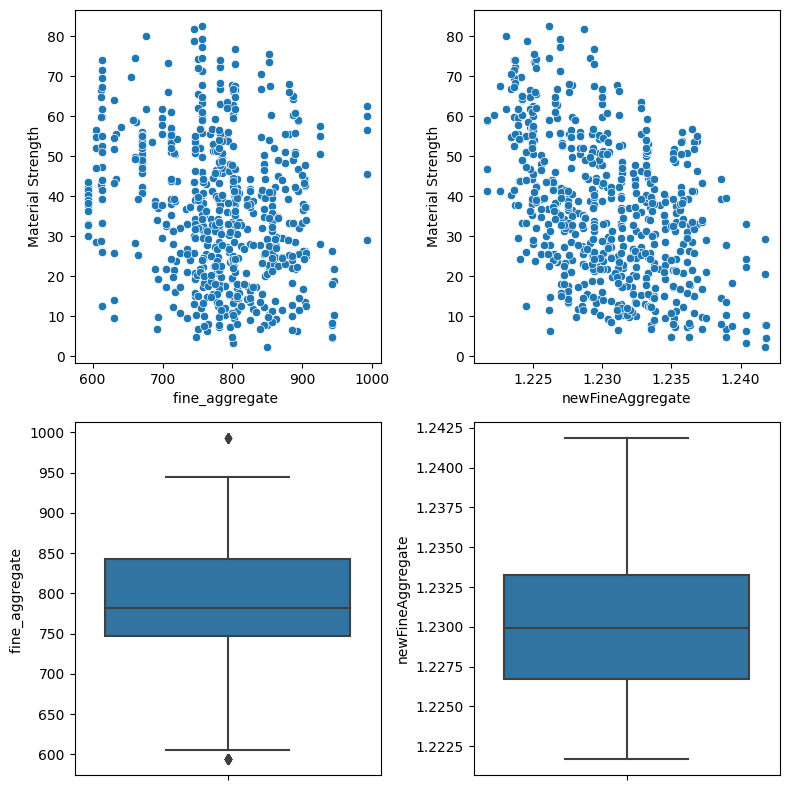

In [85]:
# handling outliers from fine aggregate
newName = "newFineAggregate"
oldName = "fine_aggregate "
trainData[newName] = 1/1+pow(1+np.log(trainData[oldName]*(trainData["cement"]**2)),-0.5)
countOutlier(trainData,oldName)
countOutlier(trainData,newName)
testFeature(trainData,newName,oldName)

outliers in  blast_furnace_slag  ==>  63
outliers in  newBlastFurnaceSlag  ==>  0
newBlastFurnaceSlag  corelation ==> 0.24048515554087044
blast_furnace_slag  corelation ==> 0.12457216764237773


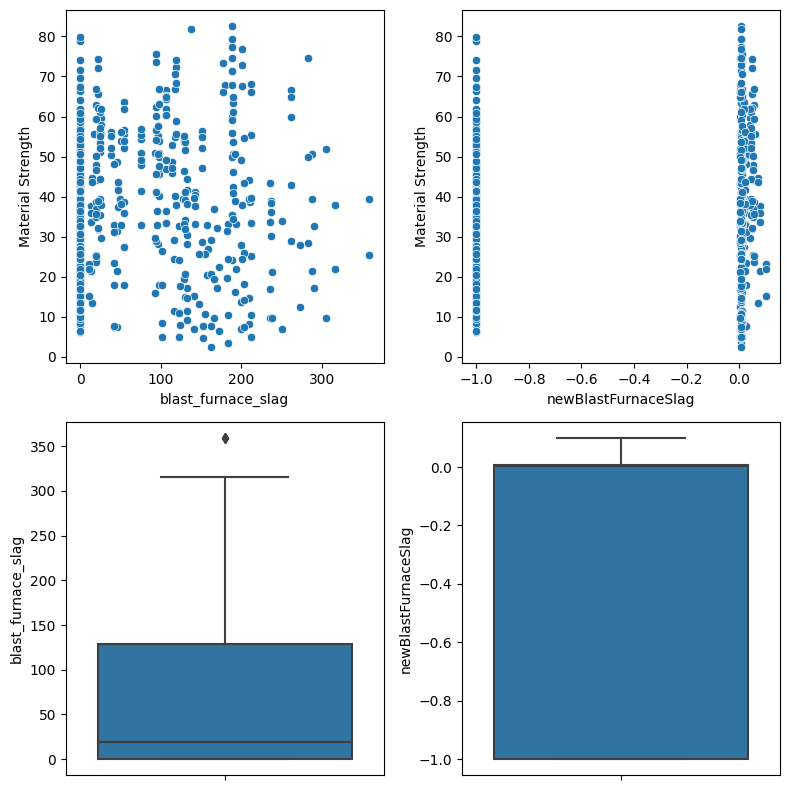

In [86]:
# handling outliers from blast furnace slag column
newName = "newBlastFurnaceSlag"
oldName = "blast_furnace_slag"
trainData[newName] = (1/(trainData[oldName]-1))
countOutlier(trainData,oldName)
countOutlier(trainData,newName)
testFeature(trainData,newName,oldName)

- Here all outliers get handled.
- NowWe have to remove duplicates. 
- Here their is no null value is present 
- Also no object data type is present.

In [87]:
print("Oiriginal shape :",trainData.shape)
trainData.drop_duplicates(inplace=True)
print("Shape after removing duplicates:",trainData.shape)
print(trainData["Material Strength"].head(10))

Oiriginal shape : (640, 16)
Shape after removing duplicates: (620, 16)
0    44.33
1    65.70
2    34.29
3    14.20
4    13.40
5    41.72
6    27.42
7    24.48
8    55.55
9    36.94
Name: Material Strength, dtype: float64


### 3.4 Preprocessing

In [88]:

object= StandardScaler()

train_A = trainData.drop("Material Strength",axis=1)
train_b = trainData["Material Strength"]

# standardization 
scale = object.fit_transform(train_A) 
train_A = pd.DataFrame(scale,columns=train_A.columns)
# plotGraph(train_A,train_A.columns,"kde")

- As we can see in kde plots most of the graph looks like normal distribution. Here graph conataining outliers are not able to scale well.

## 4. Exact Solution
Using normal equations and Pseudo-inverse to compute the optimal parameter

- Finiding exact solution as follows 
$$   Ax = b$$
$$A^TAx = A^Tb$$
$$    x = (A^TA)^{-1}b$$
- bestFitCoeffMatrix() method will return x matrix

In [89]:
# finding best fit coeffcient matrix  and predicting value over trainData
# this will show 1 x 16 matrix
train_x = bestFitCoeffMatrix(train_A,train_b).reshape((16,1))
train_p = predictValue(train_A,train_x.reshape(16,1))
print("So the matrix x is(coeff. matrix) :-")
print(train_x[:10])
print("\nPredicted Value :")
print(train_p[:10])

# Now just find errros in predicted value
train_MSE = meanSquareError(train_b,train_p)
print("\nmean square error over train data ",train_MSE)

So the matrix x is(coeff. matrix) :-
[[ 36.35722581]
 [ 38.09555605]
 [  5.04714901]
 [  1.50306336]
 [-43.41057331]
 [-10.23730712]
 [ -0.3617622 ]
 [ -7.05426073]
 [ -5.11896247]
 [ 29.33057093]]

Predicted Value :
[[46.29533626]
 [62.2606692 ]
 [32.54639792]
 [12.20938873]
 [20.90024294]
 [41.28115287]
 [25.67269511]
 [30.75493674]
 [53.56023385]
 [37.05302454]]

mean square error over train data  40.723064546138914


### 4.1 Error Calculation
- Now calculate Error
    $$ b = \text{actual value}  $$
    $$ p = \text{predicted value} $$

    1. Mean Square error
    $$ MSE =\frac{1}{n}* \sum(b_i - P_i)² $$

    2. Root Mean Square error
    $$ RMSE =\sqrt{\frac{1}{n}* \sum(b_i - p_i)²} $$

    3. $R^2$ error
    $$ R^2 = 1 - \frac{n*MSE}{\sum (\bar{b} - p_i)} $$
    $$ \text{where }\bar{b} = \frac{1}{n}\sum (b_i) $$

In [90]:
# now check on test data also 
testData = transformDataSet(testData)
train_MSE,test_MSE = getMeanSquareError(trainData=trainData,testData=testData)
print("train set error ",train_MSE)
print("test set error ", test_MSE)

train set error  40.723064546138914
test set error  40.28162598229259


- Like this way we have checked our model mean Square error, which is nearly 40 😃


### 4.2 Equation for response variable

In [91]:
# creating equation
string = "Material strength = \n"
for i in range(train_x.shape[0]):
    string += f"\t\t({train_x[i][0]} x {trainData.columns[i]}) + \n"
print(string[:-3])

Material strength = 
		(36.35722580645205 x cement) + 
		(38.09555604616571 x blast_furnace_slag) + 
		(5.047149013125502 x fly_ash) + 
		(1.5030633600564731 x water) + 
		(-43.41057331478732 x superplasticizer) + 
		(-10.237307120036808 x coarse_aggregate) + 
		(-0.36176219983269586 x fine_aggregate ) + 
		(-7.054260727427598 x age) + 
		(-5.118962469860115 x Material Strength) + 
		(29.330570929655117 x waterPerCement) + 
		(-33.20091133140671 x cementPerWaterVolume) + 
		(9.789936681991975 x fineAggregatePerWaterVolume) + 
		(15.359666325553999 x newAge) + 
		(13.650029269914699 x newSuperPlasticizer) + 
		(-16.765584324572007 x newFineAggregate) + 
		(0.35802235912472946 x newBlastFurnaceSlag) 


### 4.3 Interpretation:
- "Material Strength" is the response variable or the dependent variable that we are trying to predict.

- The equation represents a linear relationship between "Material Strength" and the predictor variables listed on the right-hand side of the equation.

- Each coefficient (e.g., 36.35722580645205 x cement) represents the impact of the corresponding predictor variable on the "Material Strength" when all other variables are held constant. For example, an increase in "cement" by one unit would lead to an increase in "Material Strength" by approximately 36.36 units, assuming all other variables remain unchanged.

- The negative coefficients (e.g., -43.41057331478732 x superplasticizer) indicate that an increase in those predictor variables would lead to a decrease in "Material Strength."

- The constant terms represent the intercept or the baseline "Material Strength" when all predictor variables are set to zero.(here no constant term inserted)

- The equation provides a mathematical model that allows you to predict the "Material Strength" based on the values of the predictor variables.

- This linear regression model assumes a linear relationship between the variables and may not capture complex nonlinear relationships that could exist in the data.

- Coefficients in the equation were determined through the linear regression analysis you performed, and they represent the best-fit values for your specific dataset.

## 5. Statistical Analysis

In [92]:
# Training another model
newTrainData , newTestData = seperateData(originalTrainData)

def transform(trainData,testData):
    for data in [trainData,testData]:
       data["newAge"] = (data["age"])**0.1
       data["ageSlag"] = data["blast_furnace_slag"] * data["newAge"] 
       data["flyAge"] = data["fly_ash"] * data["age"]
       for f in data.columns:
            if f=="Material Strength" or f=="fly_ash" or f=="fine_aggregate " :
                continue
            name = "new"+f+"1"
            data[name] = data[f]/(1+data["water"])
            # testFeature(data,name,f)
    return trainData,testData

newTrainData , newTestData = transform(newTrainData,newTestData)
train_MSE, test_MSE = getMeanSquareError(trainData=newTrainData,testData=newTestData)

print("MSE in trainData is ", train_MSE)
print("MSE in testData is ",test_MSE)

MSE in trainData is  36.974340825133936
MSE in testData is  32.99094015219754


### 5.1 Using OLS library

In [93]:
# frist model summary
print(olsStatic(trainData))

                            OLS Regression Results                            
Dep. Variable:      Material Strength   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     261.6
Date:                Tue, 12 Sep 2023   Prob (F-statistic):          1.78e-252
Time:                        16:40:37   Log-Likelihood:                -2028.8
No. Observations:                 620   AIC:                             4090.
Df Residuals:                     604   BIC:                             4161.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
cement            

In [94]:
# Second model summary
print(olsStatic(newTrainData))

                            OLS Regression Results                            
Dep. Variable:      Material Strength   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     236.4
Date:                Tue, 12 Sep 2023   Prob (F-statistic):          4.24e-274
Time:                        16:40:37   Log-Likelihood:                -2063.4
No. Observations:                 640   AIC:                             4169.
Df Residuals:                     619   BIC:                             4262.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
cement                    -0

### 5.3 Statistical Properties of Regression Models

In your provided Ordinary Least Squares (OLS) regression results for two models, we can study the statistical properties, attribute significance, and confidence intervals for each feature.

##### First Model
- **R-squared:** R-squared is a measure of how well the model fits the data. In the first model, the R-squared value is 0.867, indicating that approximately 86.7% of the variance in the response variable (Material Strength) is explained by the model.

- **Significant Features:** To determine significant features, we look at the p-values (P>|t|) in the table. Features with low p-values are considered statistically significant. In this model, the significant features include cement, blast_furnace_slag, water, superplasticizer, fine_aggregate, age, waterPerCement, fineAggregatePerWaterVolume, newAge, and newSuperPlasticizer. These features have p-values close to zero.

- **Confidence Intervals:** The confidence intervals ([0.025 0.975]) provide a range within which the true population parameter is likely to fall. For example, the coefficient for cement has a 95% confidence interval of [0.047, 0.684]. This means that we can be 95% confident that the true effect of cement on Material Strength falls within this range.

##### Second Model
- **R-squared:** The second model has an R-squared value of 0.884, indicating that it explains approximately 88.4% of the variance in Material Strength.

- **Significant Features:** Significant features in the second model are those with low p-values. These include fly_ash, superplasticizer, coarse_aggregate, age, newcement1, newblast_furnace_slag1, newwater1, newsuperplasticizer1, newcoarse_aggregate1, newage1, newageSlag1, and newflyAge1. These features have p-values close to zero.

- **Confidence Intervals:** Confidence intervals provide a range for each coefficient's true value. For instance, the coefficient for newwater1 has a 95% confidence interval of [1.47e+04, 5.86e+04]. This means we can be 95% confident that the true effect of newwater1 on Material Strength falls within this range.

##### Interpretations and Comparison
- Both models have high R-squared values, indicating that they explain a significant portion of the variance in Material Strength.

- Model 2 has a slightly higher R-squared value, suggesting it might be a better fit for the data.

- In both models, some features are statistically significant (low p-values).

- The decision between the two models could be influenced by the particular objectives and needs of our analysis. Model 2 inclued a greater number of features, allowing it to capture finer details within the data. However, there is also an increased risk of overfitting. 

- Confidence intervals provide a range of values for each coefficient, allowing you to assess the precision of the parameter estimates. Narrower intervals indicate more precise estimates.

## 6. Gradient Descent Method

### 6.1 Gradient Descent for First Model(trainData)

In [95]:
# let's apply gradient descent method to for out models and find 
trainData_x, trainErrorHistory, trainValidHist = gradientDescent(trainData,0.1,3000)
testData_x, testErrorHistory,testValidHist = gradientDescent(testData,0.1,3000)

# best coeff. matrix
print("MSE is in train Data : ",trainErrorHistory[-1])
print("MSE is in test Data : ",testErrorHistory[-1])
print("Matrix X is :\n",trainData_x)


MSE is in train Data :  41.15788822136063
MSE is in test Data :  40.96503106613125
Matrix X is :
 [[ 36.35722581]
 [  3.05540576]
 [  5.35952552]
 [  1.49821926]
 [-12.05782506]
 [-11.9218434 ]
 [ -0.0442829 ]
 [ -3.4745698 ]
 [ -5.24890942]
 [  0.25278543]
 [  6.26313815]
 [  8.16417722]
 [ 15.33560691]
 [ 15.24675218]
 [ -0.29591692]
 [  0.36492337]]


### 6.2 Gradient Descent for Second Model(newTrainData)

In [112]:
# let's apply gradient descent method to for out models and find 
newTrainData_x, trainErrorHistory, trianValidHist = gradientDescent(newTrainData,0.1,3000)
newTestData_x, testErrorHistory, testValidHist = gradientDescent(newTestData,0.1,3000)

# best coeff. matrix
print("MSE is in train Data : ",trainErrorHistory[-1])
print("MSE is in test Data : ",testErrorHistory[-1])
print("Matrix X is :\n",newTrainData_x)

MSE is in train Data :  38.02973113280761
MSE is in test Data :  34.36692960112837
Matrix X is :
 [[ 37.05760938]
 [  4.72391187]
 [ -5.64243544]
 [  2.59393162]
 [  2.38801291]
 [ 17.72024915]
 [ -7.17775259]
 [  0.43695342]
 [  3.46830778]
 [  6.48053902]
 [  1.74066474]
 [ -4.87789425]
 [  6.61743477]
 [ -1.1823975 ]
 [ 14.79110734]
 [-16.46396315]
 [ 15.1315811 ]
 [ -7.13832984]
 [  7.99432444]
 [ 12.03612821]
 [  6.49654631]]


In [113]:
# Loss curve
fig=px.line(trainErrorHistory)
fig.update_xaxes(title='Iteration')
fig.update_yaxes(title='Loss')
fig.show()

In [114]:
# Validation curve
fig=px.line(testValidHist)
fig.update_xaxes(title='Iteration')
fig.update_yaxes(title='Loss')
fig.show()

## 7. KNN

In [124]:
def calculateDistance(p1, p2, var):
    diff = (p2- p1)*var
    distance = diff.dot(diff)
    return distance 

In [126]:
def KNN_average(data, p2, k):

    corrMatrix = trainData.corr()["Material Strength"]
    corrMatrix.drop(["Material Strength"], inplace=True)
    maxCorrs = []

    for feature in trainData.columns:
        if feature != "Material Strength":
            maxCorr = np.max(trainData[feature])
            maxCorrs.append(maxCorr)
    var = corrMatrix / maxCorrs 

    features = data.drop("Material Strength", axis=1)

    distance = [calculateDistance(p2, row,var) for _,row in features.iterrows()]
    allValues = np.c_[distance, ["Material Strength"]]
    allValues = sorted(allValues, key=lambda p: p[0])
    count = 0

    for i in range(k):
        count += allValues[i][1]
        average =  count/k
        return average

In [127]:
def KNN(data, k):
    trainData,testData = seperateData(data)

    train_A= trainData.drop("Material Strength", axis=1)
    train_b = trainData["Material Strength"]

    test_A = testData.drop("Material Strength", axis=1)
    test_b = testData["Material Strength"]

    prediction = []

    for index, point in test_A.iterrows():
        pValue = KNN_average(trainData, point, k)
        prediction.append(pValue)

    error = meanSquareError(test_b,np.array(prediction))

    return error

In [128]:
KNN(trainData, k =4)
## k==4 is giving least error

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 496 and the array at index 1 has size 1

In [ ]:
KNN(originalTrainData,k=5)

## 8. Generalized Linear Models

### 8.1 Guassian Regression

In [103]:
def gaussianRegression(data):
    data.dropna(inplace=True)

    data_A = data.drop('Material Strength',axis=1)
    data_b = data['Material Strength']

    kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
    model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
    model.fit(data_A, data_b)

    prediction, sigma = model.predict(data_A, return_std=True)
    MSE = meanSquareError(data_b,prediction)
    
    return MSE


#### 8.1.1 Training Model using Guassian Model

In [104]:
# _,testData = seperateData(originalTrainData)
data = transformDataSet(originalTrainData)
MSE = gaussianRegression(data)
print(MSE)

/home/karan/.local/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/karan/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.



1.4166668010652324


### 8.2 Poisson Regression

In [105]:
def poissonRegression(trainData,testData):
    trainData.dropna(inplace=True)
    testData.dropna(inplace=True)
    
    trainData_A = trainData.drop('Material Strength',axis=1)
    trainData_b = trainData['Material Strength']

    testData_A = testData.drop('Material Strength',axis=1)
    testData_b = testData['Material Strength']

    model = PoissonRegressor()
    model.fit(trainData_A,trainData_b)

    testPrediction = model.predict(testData_A)
    trainPrediction = model.predict(trainData_A)

    testMSE = meanSquareError(testData_b,testPrediction)
    trainMSE = meanSquareError(trainData_b,trainPrediction)

    return trainMSE, testMSE

In [106]:
trainMSE,testMSE = poissonRegression(newTrainData,newTestData)
print(trainMSE,testMSE)

319.36623194116214 274.2677212307129


/home/karan/.local/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:290: RuntimeWarning:

invalid value encountered in matmul



## 9. Test Output


In [107]:
finalTrainData,finalTestData = readOriginalData()
# finalTrainData.dropna(inplace=True)

finalTrainData_A = finalTrainData.drop("Material Strength",axis=1)
finalTrainData_b = finalTrainData["Material Strength"]

finalTestData_A = finalTestData.drop("material_strength",axis=1)
finalTestData_b = finalTestData["material_strength"]

# finalTrainData_A = transformDataSet(finalTrainData_A)
# finalTestData_A = transformDataSet(finalTestData_A)

# finalTestData.info()
finalTestData_x = bestFitCoeffMatrix(finalTrainData_A,finalTrainData_b)
finalTestPredict = predictValue(finalTestData_A,finalTestData_x)

finalTestPredict[:10]
# finalTestPredict.size


array([16.09632204, 18.58828755, 26.74397463, 26.40359712, 29.37022272,
       36.72745421, 28.45519635, 30.94716185, 15.91534745, 18.58828755])

In [109]:
# from sklearn import er
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_absolute_percentage_error

solution = pd.read_csv("/home/karan/Templates/SemV_Assignments/Machine_Learning/Assingnment1/data/concrete_data_Solution.csv",header=None)

solution = np.array(solution)
predction  = np.array(finalTestPredict)

# print(predction[:10])
# print(solution[:10])
print(mean_squared_error(solution,predction))
print(mean_absolute_percentage_error(solution,predction))
print(mean_absolute_error(solution,predction))


73.94780792443224
0.2562541277931342
6.795324763319784


In [ ]:
# Save the NumPy array as a CSV file
file_path = './12140860_Karan_Asg1.csv'
np.savetxt(file_path, solution, delimiter=',')